In [39]:
import json
import csv
import re
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from operator import itemgetter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Using some stopwords from https://github.com/AlludedCrabb/sound-tasty
cooking_stop_words = list(set([
        'canned', 'cans', 'drained', 'and', 'halved', 'cup', 'cups',
        'teaspoon', 'tablespoon', 'teaspoons', 'tablespoons',
        'finely', 'freshly', 'fresh', 'thickcut', 'to', 'taste',
        'grated', 'cut', 'into', 'wedges', 'pounds', 'unpeeled', 'large',
        'minced', 'slice', 'slices', 'sliced', 'thick-cut', 'cut',
        'crosswise', 'pieces', 'toothpicks', 'low-fat', 'chopped', 'or',
        'taste', 'cooked', 'dry', 'shredded', 'beaten', 'dried', 'melted',
        'stems', 'removed', 'diced', 'ounce', 'ounces', 'packages',
        'softened', 'such', 'RedHot®', 'RedHot', 'Franks', "Frank's",
        'crumbled', 'Old', 'Bay®', 'Bay', 'pinch', 'for', 'garnish', 'slice',
        'slices', 'needed', 'inch', 'cubes', 'cooking', 'spray', 'ground',
        'rotisserie', 'lowfat', 'as', 'quarteres', 'cloves', 'more', 'can',
        'package', 'frozen', 'thawed', 'packet', 'reducedfat', 'Knorr',
        'container', 'pound', 'peeled', 'deveined', 'seeded', 'ripe',
        'English', 'juiced', 'plus', 'more', 'Hass', 'cubed', 'Mexicanstyle',
        'hearts', 'prepared', 'party', 'pitted', 'mashed',
        'roma', 'optional', 'chunk', 'Hot', 'bunch', 'cleaned', 'box',
        'chickenflavored', 'Golden', 'delicious', 'cored', 'any', 'flavor',
        'flavored', 'whole', 'allpurpose', 'all', 'purpose', 'deep', 'frying',
        'dash', 'packed', 'in', 'French', 'jar', 'small', 'head', 'little',
        'smokie', 'seasoned', 'Boston', 'Bibb', 'leaves', 'lean', 'pickled',
        'Asian', 'dark', 'flaked', 'rolled', 'packed', 'jellied',
        'thirds', 'with', 'attached', 'skewers', 'skinless', 'boneless',
        'half', 'kernels', 'rinsed', 'quart', 'quarts', 'kernel',
        'Italianstyle', 'unpopped', 'lightly', 'coating', 'SAUCE',
        'lengthwise', 'miniature', 'semisweet', 'rinsed', 'round',
        'squeezed', 'stewed', 'raw', 'the', 'liquid', 'reserved', 'medium',
        'instant', 'solid', 'pack', 'refrigerated', 'halves', 'distilled',
        'loaf', 'extra', 'virgin', 'crushed', 'kosher', 'toasted', 'buttery',
        'TM', 'panko', 'Japanese', 'regular', 'bottle', 'bottles', 'thin',
        'peel', 'paper', 'thick', 'circles', 'unbleached',
        'breast', 'breasts', 'wings', 'strips', 'jumbo', 'giant', 'chunks',
        'quickcooking', 'sweetened', 'flakes', 'Ranchstyle', 'snipped',
        'food', 'ROTEL', 'Italian', 'sticks', 'stick', 'crescent', 'thinly',
        'boiled', 'Genoa', 'roasted', 'thin', 'extrasharp', 'pressed',
        'sifted', 'split', 'tips', 'discarded', 'mini', 'deli', 'drain',
        'reserve', 'diameter', 'Greek', 'Thai', 'drops', 'square', 'crusty',
        'American', 'selfrising', 'imitation', 'Wings', 'apart', 'at',
        'joints', 'wing', 'tips', 'discarded', 'parts',
        'tops', 'seperated', 'blend', 'coarsely', 'sweet', 'stalk', 'heads',
        'husked', 'divided', 'pats', 'unsalted', 'active', 'warm', 'sea',
        'separated', 'herb', 'overripe', 'degrees', 'F', 'C', 'room',
        'temperature', 'machine', 'very', 'pint', 'puree', 'coarse',
        'envelopes', 'lukewarm', 'creamstyle', 'unsweetened',
        'lite', 'of', 'chilled', 'freezer', 'cold', 'brushing', 'nonfat',
        'squares', 'tails', 'thigh', 'quarters', 'Masterpiece', 'KC', 'from',
        'El', 'Paso', 'bulk', 'Hunts', 'Roma', 'light', 'fluid', 'lagerstyle',
        'stalks', 'quartered', 'undrained', 'drained', 'Tony', 'Chacheres',
        'lump', 'uncooked', 'cube', 'bits', 'hair', 'angel', 'trimmed',
        'stew', 'spaghetti', 'brisket', 'bitesized', 'matchstick', 'Chobani',
        'unbaked', 'crust', 'torn', 'bonein', 'pounded', 'bitesize',
        'granules', 'boiling', 'yolk', 'coloring', 'pinch', 'a', 'blender',
        'fine', 'which', 'extralarge', 'use', 'will', 'make', 'garnish',
        'barely', 'moistened', 'about', 'right', 'before', 'serving', 'mix', 
        'thinly-sliced', 'thinly-sliced', 'etc', 'excess', 'granulated'
        ]))

unhelpful = list(set(['fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 
             'mild', 'hot', 'minced', 'dark roast', 'unsifted', 'canned', 
             'cans', 'drained', 'halved', 'finely', 'freshly', 'thickcut', 
             'grated', 'cut', 'unpeeled', 'large', 'minced', 'slice', 
             'slices', 'sliced', 'chopped','shredded', 'beaten', 'dried', 
             'melted', 'stems', 'softened', 'packages', 'crumbled', 'ground',
             'low-fat', 'rotisserie', 'lowfat', 'can', 'thawed', 'packet', 
             'reducedfat', 'small', 'pats', 'regular', 'lukewarm', 'mashed', 
             'stalk', 'breast', 'breasts', 'juiced', 'halves', 'extrasharp', 
             'sharp', 'extra sharp', 'frozen', 'raw', 'warm', 'divided', 
             'little', 'squares', 'thinly', 'thick', 'rinsed', 'toasted', 
             'bitesize', 'chunks', 'refrigerated', 'kernel', 'kernels', 
             'jar', 'lengthwise', 'unpeeled', 'cleaned', 'paper', 'melted', 
             'separated', 'seperated', 'deveined', 'party', 'bunch', 'overripe', 
             'boiled', 'chunk', 'container', 'bitesized', 'sweet', 'strips', 
             'sifted', 'roma', 'very', 'undrained', 'stewed', 'thawed', 'lean', 
             'roasted', 'extra', 'lite', 'coarsely', 'pressed', 'square', 
             'jumbo', 'yolk', 'yolks', 'barely', 'pitted', 'cored', 'puree', 
             'cubes', 'angel', 'hair', 'angelhair', 'giant', 'husked', 'chilled', 
             'thigh', 'trimmed', 'thin', 'lightly', 'cubed', 'drops', 'grated', 
             'boneless', 'unsalted', 'pieces', 'skinless', 'pounded', 
             'chickenflavored', 'extralarge', 'medium', 'reserve', 'unbaked', 
             'crushed', 'wings', 'crosswise', 'cold', 'bonein', 'bone in', 
             'squeezed', 'kosher', 'miniature', 'tails', 'quarters', 'attached', 
             'loaf', 'dry', 'more', 'head', 'removed', 'packed', 'hearts', 
             'matchstick', 'unbleached', 'heads', 'stems', 'sea', 'diced', 
             'mini', 'cut', 'unpopped', 'box', 'uncooked', 'freezer', 'stalks', 
             'shredded', 'halved', 'snipped', 'thick-cut', 'split', 'seeded', 
             'sweetened', 'discarded', 'lump', 'boiling', 'whole', 'semisweet', 
             'semi-sweet', 'quartered', 'moistened', 'reserved', 'prepared', 
             'fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 'mild', 
             'hot', 'minced', 'dark roast', 'unsifted', 'quaker', 'raw', 'frozen', 
             'calore-wise', 'ziploc bag', 'real', 'lite', 'crisp', 'decaffeinated', 
             'canned', 'processed', 'cooked', 'unpeeled', 'also', 'store-bought',]))

brands = ['rotel', 'absolut', 'betty crocker', 'jello', 'diana', 'ener-g', 
          'del-monte', "hunt's", 'martha', 'goya', 'cracker barrel', 
          'hamburger helper', "mccormick's", 'pepperidge farm', 'knorr', 
          'godiva', 'hidden valley', 'tabasco', 'branston', "kellogg's", 
          'hodgson mill', 'kraft', 'johnsonville', 'jim beam', 'mccormick', 
          'equal', 'jell-o', 'jimmy dean', 'country bob', "smucker's", 
          'toblerone', 'gerber', 'nestle', 'nestl', 'malt-o-meal', 'triscuit', 
          'ragu', 'campbell', 'hormel', 'earth balance', 'pillsbury', 
          "bird's eye", "campbell's", "betty crocker's", 'gold medal', 
          'crystal light', 'milnot', "land o' lakes", 'herb-ox', 'quaker',
          'coffee-mate', 'contadina', 'j&d', 'fantastic foods', 'bacardi', 
          'eckrich', 'little smokies', 'snickers', 'ortega', 'bayou blast', 
          "annie's", 'mrs. dash', 'mori-nu', 'old el paso', 'original supreme',
          'morton', 'nabisco', 'rice-a-roni', 'stolichnaya', "lawry's", 
          'st. germain', "eggland's best", 'club house "lagrille"', 'hostess',
          'giada de laurentiis genovese', '*available in most target stores', 
          'jarlsberg', 'pillsbury plus', 'ro-tel', 'pillsbury grands', 
          'shilling', 'hershey', 'hershey carb alternatives', 'pasta roni', 
          'pastaroni', 'torani', 'v8', 'v8 fusion', 'ghiradelli', 'oscar mayer',
          "bird's", 'smithfield', 'cadbury', 'sun-maid', 'karo', 
          'wishbone deluxe', 'vochelle', 'laughing cow', 'omega', 'stirrings',
          'duncan hines', 'barilla', 'carnation', 'bertolli', 'bertolli®',
          'breyers®', "1/2", "14.5", "''", "'s", "best®", "bell®", "bragg", 
          "crystal®", "crock®", "foods®", "frank's®", "gold®", "hellmann's®",
          "johnsonville®", "knorr®", "lipton®", "n't", "n", "pillsbury™", 
          "progresso™", "progresso", "ranch®", "secrets®", "valley®", "vay®",
          "yoplait®", "®", "’", 
         ]

measures = ['cup', 'cups', 'pound', 'pounds', 'teaspoon', 'tsp', 'teaspoons', 
            'tablespoon', 'tablespoons', 'tbs', 'ounce', 'ounces', 'oz', 'see', 
            'note', 'lb', 'lbs', '¼', '½', '⅓', '⅔']


stopwords_list = stopwords.words('english') + list(string.punctuation) + unhelpful\
                 + brands + measures
lemmatizer = WordNetLemmatizer()

In [4]:
filename = "../raw_data/recipes-en-201706/epicurious-recipes_m2.json"
with open(filename, 'r') as f:
    datastore = json.load(f)

In [11]:
datastore[0]['tag']['category']

'ingredient'

In [45]:
len(datastore)

34756

In [30]:
[(listing['tag']['category'], listing['tag']['name']) for listing in datastore[:0] if listing['tag']['category'] =='cuisine']

KeyError: 'tag'

In [33]:
all_with_cuisine = []
for listing in datastore:
    try: 
        if listing['tag']['category'] == 'cuisine':
            all_with_cuisine.append((listing['tag']['category'], listing['tag']['name']))
    except:
        pass

In [34]:
all_with_cuisine

[('cuisine', 'Italian'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'French'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Asian'),
 ('cuisine', 'Cajun/Creole'),
 ('cuisine', 'Italian'),
 ('cuisine', 'American'),
 ('cuisine', 'French'),
 ('cuisine', 'American'),
 ('cuisine', 'Middle Eastern'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Spanish/Portuguese'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'American'),
 ('cuisine', 'Asian'),
 ('cuisine', 'African'),
 ('cuisine', 'Moroccan'),
 ('cuisine', 'Indian'),
 ('cuisine', 'Indian'),
 ('cuisine', 'American'),
 ('cuisine', 'American'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Thai'),
 ('cuisine', 'Italian'),
 ('cuisine', 'American'),
 ('cuisine', 'French'),
 ('cuisine', 'African'),
 ('cuisine', 'Asian'),
 ('cuisine', 'American'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Mexican'),
 ('cuisine', 'French'),
 ('cuisine', 'Asian'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Fre

In [35]:
len(all_with_cuisine)

14847

In [36]:
all_cuisines = []
for listing in datastore:
    try: 
        if listing['tag']['category'] == 'cuisine':
            all_cuisines.append(listing['tag']['name'])
    except:
        pass

In [37]:
len(set(all_cuisines))

33

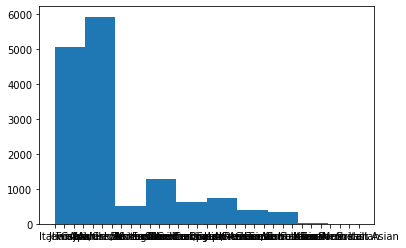

In [40]:
plt.hist(all_cuisines);

In [42]:
pd.Series(all_cuisines).value_counts()

American                      5480
Italian                       2121
French                        1294
Asian                         1268
Mexican                        809
Indian                         355
Jewish                         353
Mediterranean                  323
Spanish/Portuguese             307
Middle Eastern                 289
Greek                          284
English                        225
Central American/Caribbean     189
Eastern European/Russian       167
Central/South American         151
Southwestern                   150
Cajun/Creole                   144
Scandinavian                   131
Irish                          121
Thai                           120
Moroccan                       117
Chinese                        115
African                         92
Japanese                        90
German                          80
Vietnamese                      57
Latin American                   3
Tex-Mex                          3
Korean              

In [ ]:
url = datastore[0]['recipe']['url']

In [ ]:
[item['food'] for item in datastore[0]['recipe']['ingredients']]

In [ ]:
urls = []
labels = []
sources = []
ingreds = []

for recipe in datastore:
    recipe_path = recipe['recipe']
    urls.append(recipe_path['url'])
    labels.append(recipe_path['label'])
    sources.append(recipe_path['source'])
    ingreds.append([item['food'] for item in recipe_path['ingredients']])
    
all_recipes = {'url': urls,
               'label': labels, 
               'source': sources, 
               'ingredients': ingreds
              }

recipe_df = pd.DataFrame(all_recipes)

In [ ]:
recipe_df

In [ ]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [ ]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            return frac_str
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
def tokenize_recipes(df):
    token_recipes = []
    for recipe in df['ingredients']:
        tokens = [word_tokenize(word) for word in recipe]
        flat_tkns = list(_flatten(tokens))
        stopped_tokens = [ w.lower() #re.search([0-9]+\/[0-9]+,
                          for w in flat_tkns 
                          if w not in stopwords_list 
                          if (isFloat(w) == False)]
        lemma_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
        token_recipes.append(lemma_tokens)
    return token_recipes

In [ ]:
def _flatten(list_of_lists):
    for x in list_of_lists:
        if hasattr(x, '__iter__') and not isinstance(x, str):
            for y in _flatten(x):
                yield y
        else:
            yield x

In [ ]:
all_ingreds = tokenize_recipes(recipe_df)
all_ingreds

In [ ]:
'bone' in(set(list(_flatten(all_ingreds))))

In [ ]:
list(_flatten(all_ingreds))

In [ ]:
test = set(all_ingreds[1]).intersection(_flatten(all_ingreds))
test

In [ ]:
isFloat('1/3')

In [ ]:
convert_to_float('1/3')

In [ ]:
for element in recipe_df['ingredients'][1]:
    print(re.search('[0-9]+\/[0-9]+', element.lower()))

In [ ]:
for element in recipe_df['ingredients'][1]:
    print(element)

In [47]:
datastore_df = pd.DataFrame(datastore)

In [48]:
datastore_df.head()

,id,dek,hed,pubDate,author,type,url,photoData,tag,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,dateCrawled
0,54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,2014-08-19T04:00:00.000Z,[],recipe,/recipes/food/views/pickle-brined-fried-chicke...,"{'id': '54a2b64a6529d92b2c003409', 'filename':...","{'category': 'ingredient', 'name': 'Chicken', ...",3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,1498547035
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,2008-09-09T04:00:00.000Z,[{'name': 'Edda Servi Machlin'}],recipe,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","{'category': 'cuisine', 'name': 'Italian', 'ur...",3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,1498547740
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,2008-09-10T04:00:00.000Z,[{'name': 'Marcy Goldman'}],recipe,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,1498547738
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,2008-09-08T04:00:00.000Z,[{'name': 'Faye Levy'}],recipe,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,1498547740
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2008-09-09T04:00:00.000Z,[{'name': 'Joan Nathan'}],recipe,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","{'category': 'cuisine', 'name': 'Jewish', 'url...",2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,1498547740


In [52]:
datastore_df_reduced = datastore_df.drop(['pubDate', 
                   'author', 
                   'type', 
                   'aggregateRating', 
                   'reviewsCount', 
                   'willMakeAgainPct', 
                   'dateCrawled'], 
                  axis=1)

In [53]:
df_flattened = pd.concat([datastore_df_reduced.drop(['tag'], axis=1), 
           datastore_df_reduced['tag'].apply(pd.Series)], axis=1)

In [58]:
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34756 entries, 0 to 34755
Data columns (total 15 columns):
id                       34756 non-null object
dek                      34756 non-null object
hed                      34756 non-null object
url                      34756 non-null object
photoData                34756 non-null object
ingredients              34656 non-null object
prepSteps                34756 non-null object
0                        0 non-null float64
category                 34655 non-null object
name                     34655 non-null object
photosBadgeAltText       34655 non-null object
photosBadgeFileName      34655 non-null object
photosBadgeID            34655 non-null object
photosBadgeRelatedUri    34655 non-null object
url                      34655 non-null object
dtypes: float64(1), object(14)
memory usage: 4.0+ MB


In [59]:
df_flattened[:20]

,id,dek,hed,url,photoData,ingredients,prepSteps,0,category,name,photosBadgeAltText,photosBadgeFileName,photosBadgeID,photosBadgeRelatedUri,url
0,54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,/recipes/food/views/pickle-brined-fried-chicke...,"{'id': '54a2b64a6529d92b2c003409', 'filename':...","[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,NaN,ingredient,Chicken,,,,,
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,NaN,cuisine,Italian,,,,,
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,NaN,cuisine,Jewish,,,,,
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",NaN,cuisine,Jewish,,,,,
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",NaN,cuisine,Jewish,,,,,
5,54a408a919925f464b3733d3,Although Nelly Custis omitted sugar in her rec...,Rice Pancakes,/recipes/food/views/rice-pancakes-394729,"{'id': '56746183b47c050a284a4e15', 'filename':...","[1 1/2 cups cooked rice, 2 cups heavy cream, 2...","[1. Combine the rice, cream, and butter. Add t...",NaN,ingredient,Milk/Cream,,,,,
6,54a408aa19925f464b3733d6,Editor's note: This recipe is adapted with per...,Jack-O'-Lantern,/recipes/food/views/jack-o-lantern-350068,"{'id': '560d7907f9a841923089d7da', 'filename':...","[2 tablespoons shortening, 2 tablespoons flour...",[1. Preheat the oven to 350°F. Lightly grease ...,NaN,type,Cake,,,,,
7,54a408ab19925f464b3733da,Editor's note: This recipe is reprinted with p...,Seven-Minute Frosting,/recipes/food/views/seven-minute-frosting-350069,"{'id': '5674617eb47c050a284a4e11', 'filename':...","[1 1/2 cups sugar, 1/3 cup cold water, 2 egg w...","[1. Combine the sugar, water, egg whites, and ...",NaN,equipment,Mixer,,,,,
8,54a408ac19925f464b3733de,Editor's note: This recipe is reprinted with p...,Creamy White Frosting,/recipes/food/views/creamy-white-frosting-350079,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 cup vegetable shortening, 1 1/2 teaspoons v...","[1. With a mixer on medium speed, beat togethe...",NaN,equipment,Mixer,,,,,
9,54a408ac6529d92b2c003653,Editor's note: This recipe is reprinted with p...,Host of Ghosts,/recipes/food/views/host-of-ghosts-350067,"{'id': '560d7907f9a841923089d7d6', 'filename':...","[One purchased 9-inch angel food cake, 2 recip...",[1. Place the cake on the cake plate. Reserve ...,NaN,type,Cake,,,,,


In [64]:
df_flattened.columns

Index([                   'id',                   'dek',
                         'hed',                   'url',
                   'photoData',           'ingredients',
                   'prepSteps',                       0,
                    'category',                  'name',
          'photosBadgeAltText',   'photosBadgeFileName',
               'photosBadgeID', 'photosBadgeRelatedUri',
                         'url'],
      dtype='object')

In [78]:
df_flattened_cleaned = df_flattened.drop([0,
                                          'photosBadgeAltText',
                                          'photosBadgeFileName',
                                          'photosBadgeID', 
                                          'photosBadgeRelatedUri'], axis=1)

In [79]:
df_flattened_cleaned

,id,dek,hed,url,photoData,ingredients,prepSteps,category,name,url
0,54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,/recipes/food/views/pickle-brined-fried-chicke...,"{'id': '54a2b64a6529d92b2c003409', 'filename':...","[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,ingredient,Chicken,
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,cuisine,Italian,
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,cuisine,Jewish,
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",cuisine,Jewish,
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",cuisine,Jewish,
...,...,...,...,...,...,...,...,...,...,...
34751,59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,/recipes/food/views/waffled-ham-and-cheese-mel...,"{'id': '595420c2d52ca90dc28200e6', 'filename':...","[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",tag,Small Plates,
34752,5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,/recipes/food/views/maple-butter,"{'id': '5674617eb47c050a284a4e11', 'filename':...","[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,meal,Breakfast,
34753,595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,/recipes/food/views/waffled-macaroni-and-cheese,"{'id': '5954259cd83a053f4d33bc74', 'filename':...","[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,tag,Small Plates,
34754,5956638625dc3d1d829b7166,A classic Mexican beer cocktail you can sip al...,Classic Michelada,/recipes/food/views/classic-michelada,"{'id': '595553ce0eda38330f0a0a63', 'filename':...","[Coarse salt, 2 lime wedges, 2 ounces tomato j...",[Place about 1/4 cup salt on a small plate. Ru...,ingredient,Beer,


In [85]:
cols = ['id', 'description', 'title', 'url', 'photo_data', 'ingredients', 'steps', 'category', 'name', 'remove']

In [86]:
df_flattened_cleaned.columns = cols
df_flattened_cleaned.columns

Index(['id', 'description', 'title', 'url', 'photo_data', 'ingredients',
       'steps', 'category', 'name', 'remove'],
      dtype='object')

In [87]:
df_flat_cln = df_flattened_cleaned.drop('remove', axis=1)

In [88]:
df_flat_cln

,id,description,title,url,photo_data,ingredients,steps,category,name
0,54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,/recipes/food/views/pickle-brined-fried-chicke...,"{'id': '54a2b64a6529d92b2c003409', 'filename':...","[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,ingredient,Chicken
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,cuisine,Italian
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,cuisine,Jewish
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",cuisine,Jewish
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",cuisine,Jewish
...,...,...,...,...,...,...,...,...,...
34751,59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,/recipes/food/views/waffled-ham-and-cheese-mel...,"{'id': '595420c2d52ca90dc28200e6', 'filename':...","[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",tag,Small Plates
34752,5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,/recipes/food/views/maple-butter,"{'id': '5674617eb47c050a284a4e11', 'filename':...","[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,meal,Breakfast
34753,595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,/recipes/food/views/waffled-macaroni-and-cheese,"{'id': '5954259cd83a053f4d33bc74', 'filename':...","[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,tag,Small Plates
34754,5956638625dc3d1d829b7166,A classic Mexican beer cocktail you can sip al...,Classic Michelada,/recipes/food/views/classic-michelada,"{'id': '595553ce0eda38330f0a0a63', 'filename':...","[Coarse salt, 2 lime wedges, 2 ounces tomato j...",[Place about 1/4 cup salt on a small plate. Ru...,ingredient,Beer


In [90]:
labeled_cuisine_df = df_flat_cln[df_flat_cln['category'] == 'cuisine']
labeled_cuisine_df

,id,description,title,url,photo_data,ingredients,steps,category,name
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,cuisine,Italian
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,cuisine,Jewish
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",cuisine,Jewish
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",cuisine,Jewish
22,54a408c36529d92b2c0036a1,Pomegranate juice adds tartness to this famous...,Apple and Pomegranate Tart Tartin,/recipes/food/views/apple-and-pomegranate-tart...,"{'id': '560d7911f9a841923089d7fe', 'filename':...","[1 cup all purpose flour, 2 tablespoons sugar,...",[Blend first 3 ingredients in processor 5 seco...,cuisine,French
...,...,...,...,...,...,...,...,...,...
34399,587fabfecd2508314395ad8c,"A whole chicken, poached in a ginger and anise...",Soy Sauce Chicken,/recipes/food/views/soy-sauce-chicken,"{'id': '587fa8d8b3246f1f0afae6a0', 'filename':...","[1 (3 1/4-lb/1.5-kg) whole chicken, 1 tablespo...",[Air-dry the chicken in the refrigerator for 3...,cuisine,Chinese
34417,588a417612082e6b03c03d27,"Sweet, spicy, and refreshing all in one, this ...",Cabbage Stir-Fry With Coconut and Lemon,/recipes/food/views/cabbage-stir-fry-with-coco...,"{'id': '5877b0363b8997bc108a4481', 'filename':...","[1/4 cup unsweetened grated coconut (fresh, fr...",[Thaw frozen coconut or soak dried coconut in ...,cuisine,Indian
34432,58924da769cf1107794eb164,Serve this meatless main—made by frying torn-u...,Amaya’s Migas,/recipes/food/views/amayas-migas,"{'id': '589e007981a60af57a05cc4c', 'filename':...","[1 tablespoon vegetable oil, 2 cups dime-sized...",[Heat the oil in a large skillet over medium h...,cuisine,Tex-Mex
34704,594006de68bd4e58aaab1d26,"Served with a side of plain jasmine rice, chic...",Home-Style Chicken Kebat,/recipes/food/views/home-style-burmese-chicken...,"{'id': '5942fbf4a76fcc25997a352f', 'filename':...","[1 1/2 pounds boneless, skinless chicken thigh...",[Slice the chicken into strips no wider than a...,cuisine,Southeast Asian


In [95]:
def cuisine_namer(text):
    if text == 'Central American/Caribbean':
        return 'Caribbean'
    elif text == 'Jewish':
        return 'Kosher'
    elif text == 'Eastern European/Russian':
        return 'Eastern Europe'
    elif text in ['Spanish/Portuguese', 'Greek']:
        return 'Mediterranean'
    elif text == 'Central/South American':
        return 'Latin American'
    elif text == 'Sushi':
        return 'Japanese'
    elif text == 'Southern Italian':
        return 'Italian'
    else:
        return text

In [98]:
labeled_cuisine_df['imputed_label'] = labeled_cuisine_df['name'].apply(cuisine_namer)

//anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
labeled_cuisine_df

,id,description,title,url,photo_data,ingredients,steps,category,name,imputed_label
1,54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,/recipes/food/views/spinach-jewish-style-350152,"{'id': '56746182accb4c9831e45e0a', 'filename':...","[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,cuisine,Italian,Italian
2,54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,/recipes/food/views/majestic-and-moist-new-yea...,"{'id': '55e85ba4cf90d6663f728014', 'filename':...","[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,cuisine,Jewish,Kosher
3,54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,/recipes/food/views/the-b-l-a-bagel-with-lox-a...,"{'id': '5674617e47d1a28026045e4f', 'filename':...","[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",cuisine,Jewish,Kosher
4,54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,/recipes/food/views/shakshuka-a-la-doktor-shak...,"{'id': '56746183b47c050a284a4e15', 'filename':...","[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",cuisine,Jewish,Kosher
22,54a408c36529d92b2c0036a1,Pomegranate juice adds tartness to this famous...,Apple and Pomegranate Tart Tartin,/recipes/food/views/apple-and-pomegranate-tart...,"{'id': '560d7911f9a841923089d7fe', 'filename':...","[1 cup all purpose flour, 2 tablespoons sugar,...",[Blend first 3 ingredients in processor 5 seco...,cuisine,French,French
...,...,...,...,...,...,...,...,...,...,...
34399,587fabfecd2508314395ad8c,"A whole chicken, poached in a ginger and anise...",Soy Sauce Chicken,/recipes/food/views/soy-sauce-chicken,"{'id': '587fa8d8b3246f1f0afae6a0', 'filename':...","[1 (3 1/4-lb/1.5-kg) whole chicken, 1 tablespo...",[Air-dry the chicken in the refrigerator for 3...,cuisine,Chinese,Chinese
34417,588a417612082e6b03c03d27,"Sweet, spicy, and refreshing all in one, this ...",Cabbage Stir-Fry With Coconut and Lemon,/recipes/food/views/cabbage-stir-fry-with-coco...,"{'id': '5877b0363b8997bc108a4481', 'filename':...","[1/4 cup unsweetened grated coconut (fresh, fr...",[Thaw frozen coconut or soak dried coconut in ...,cuisine,Indian,Indian
34432,58924da769cf1107794eb164,Serve this meatless main—made by frying torn-u...,Amaya’s Migas,/recipes/food/views/amayas-migas,"{'id': '589e007981a60af57a05cc4c', 'filename':...","[1 tablespoon vegetable oil, 2 cups dime-sized...",[Heat the oil in a large skillet over medium h...,cuisine,Tex-Mex,Tex-Mex
34704,594006de68bd4e58aaab1d26,"Served with a side of plain jasmine rice, chic...",Home-Style Chicken Kebat,/recipes/food/views/home-style-burmese-chicken...,"{'id': '5942fbf4a76fcc25997a352f', 'filename':...","[1 1/2 pounds boneless, skinless chicken thigh...",[Slice the chicken into strips no wider than a...,cuisine,Southeast Asian,Southeast Asian


In [115]:
labels = labeled_cuisine_df['imputed_label'].tolist()

In [110]:
all_recipes_ingredients = labeled_cuisine_df['ingredients'].tolist()

In [111]:
all_recipes_ingredients

[['3 pounds small-leaved bulk spinach',
  'Salt',
  '1/2 cup dark seedless raisins',
  '1 cup lukewarm water',
  '6 tablespoons olive oil',
  '1/2 small onion, minced',
  '1/4 cup pignoli (pine nuts)',
  'Freshly ground black pepper',
  'Dash nutmeg'],
 ['3 1/2 cups all-purpose flour',
  '1 tablespoon baking powder',
  '1 teaspoon baking soda',
  '1/2 teaspoon salt',
  '4 teaspoons ground cinnamon',
  '1/2 teaspoon ground cloves',
  '1/2 teaspoon ground allspice',
  '1 cup vegetable oil',
  '1 cup honey',
  '1 1/2 cups granulated sugar',
  '1/2 cup brown sugar',
  '3 eggs',
  '1 teaspoon vanilla extract',
  '1 cup warm coffee or strong tea',
  '1/2 cup fresh orange juice',
  '1/4 cup rye or whisky (see Note)',
  '1/2 cup slivered or sliced almonds (optional)'],
 ['1 small ripe avocado, preferably Hass (see Note)',
  '1 teaspoon fresh lemon juice, or to taste',
  'Salt and freshly ground black pepper',
  '',
  '2 bagels',
  '2 slices or 4 thin strips of lox, or smoked salmon',
  '2 thin

In [112]:
def _flatten(list_of_lists):
    for x in list_of_lists:
        if hasattr(x, '__iter__') and not isinstance(x, str):
            for y in _flatten(x):
                yield y
        else:
            yield x

In [124]:
def list_tokenizer(doc):
    token_recipes = []
    for sen in doc:
        tokens = [word_tokenize(word) for word in sen]
        flat_tkns = list(_flatten(tokens))
        stopped_tokens = [w.lower() for w in flat_tkns if w not in stopwords_list if (w.isnumeric() == False)]
        lemma_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
        print(lemma_tokens)
        token_recipes.append(lemma_tokens)
    return token_recipes

In [114]:
def dummy_fun(doc):
    return doc

In [116]:
X_train, X_test, y_train, y_test = train_test_split(all_recipes_ingredients, 
                                                    labels, test_size=0.2, random_state=10)

In [125]:
X_train_tokens = list_tokenizer(X_train)

['water', 'quinoa', 'well', 'currant', 'salt', '1/4', 'extra-virgin', 'olive', 'oil', 'carrot', 'peeled', 'zucchini', 'hungarian', 'paprika', 'cinnamon', 'cilantro']
['bacon', '6-ounce', 'russet', 'potato', 'peeled', '1/2-inch', 'onion', '3/4', 'celery', 'bay', 'leaf', 'milk', '10-ounce', 'package', 'corn', '3/4-ounce', 'creamed', 'corn', '1/4', 'vegetable', 'broth', 'celery', 'leaf', '1/4', 'pepper', 'sauce']
['nonstick', 'vegetable', 'oil', 'spray', 'purpose', 'flour', 'white', 'wheat', 'flour', 'wheat', 'flour*', 'medium-grind', 'grain', 'cornmeal', 'cornmeal', 'sugar', 'salt', 'baking', 'powder', '1/4', 'buttermilk', 'stick', 'butter', 'pure', 'maple', 'syrup', 'egg', 'maple', 'extract', '3/4', 'pecan', 'plus', 'pecan', 'garnish', '3/4', 'cranberry']
['udon', 'flour', 'tip', 'high-gluten', 'white', 'wheat', 'flour', 'salt', 'dissolved', '3/4', 'water']
['1-1/2', 'all-purpose', 'flour', 'pinch', 'salt', 'butter', 'about', 'water', 'apple', 'preferably', 'mix', 'tart', 'peeled', 'wat

['poblano', 'chile', 'jalapeño', 'chile', 'tomato', 'oregano', 'cilantro', '1/3', 'green', 'hulled', 'pumpkin', 'seed', 'ear', 'corn', 'white', 'onion', '1/2-inch-thick', 'round', 'garlic', 'clove', 'cumin', '1/4', 'olive', 'oil', 'short', 'pasta', 'gemelli', 'rotini', 'queso', 'fresco', 'mexican', 'cheese', 'ricotta', 'salata', 'cheese', 'garnish', 'cilantro', 'leaf']
['orange', 'peel', 'white', 'pith', 'red', 'bell', 'pepper', 'green', 'onion', 'red', 'green', 'jalepeño', 'chili', '1/4', 'cilantro', 'oriental', 'sesame', 'oil', 'peeled', 'ginger', 'soy', 'sauce', '7-ounce', 'spring', 'roll', 'large', 'radiccio', 'leaf']
['1/3', 'white', 'miso', 'fermented', 'soybean', 'paste', '1/4', 'plus', 'mirin', 'japanese', 'rice', 'wine', 'unseasoned', 'rice', 'vinegar', 'peeled', 'ginger', 'sesame', 'oil', 'asian', '6-ounce', 'black', 'cod', 'fillet', 'green', 'onion', 'sunflower', 'sprout']
['seedless', 'red', 'grape', 'tawny', 'port', 'low-salt', 'chicken', 'broth', 'rosemary', 'seedless', '

['1/2-lb', 'live', 'lobster', 'lobster', 'meat', 'red', 'potato', 'ear', 'corn', 'lemon', 'juice', 'tarragon', 'dijon', 'mustard', 'salt', '1/4', 'extra-virgin', 'olive', 'oil', 'grape', 'cherry', 'tomato', 'frisée', 'french', 'curly', 'endive', '1/3', 'scallion']
['1/4', 'guanciale', 'salt-cured', 'pork', 'jowl', 'pancetta', '1/3', 'egg', 'egg', 'rigatoni', 'kosher', 'salt', 'pecorino', 'parmesan', 'plus', 'garnish', '3/4', 'green', 'peppercorn', '3/4', 'pink', 'pepper', 'white', 'pepper', 'freshly', 'black', 'pepper', 'ingredient', 'info', 'guanciale', 'available', 'specialty', 'food', 'store', 'italian', 'market', 'zingermans.com']
['3/4', 'plus', '1/3', 'purpose', 'flour', 'sugar', 'cinnamon', 'salt', '3/4', 'stick', 'butter', '1-pound', 'bag', 'blueberry', '1-pound', 'bag', 'raspberry', '1-pound', 'bag', 'blackberry', 'vanilla', 'extract']
['1/4', 'breadcrumb', 'hazelnut', '1/3', 'milk', 'butter', 'purpose', 'flour', '3/4', 'cheddar', 'cheese', 'egg', 'egg', 'white', 'lemon', 'jui

['extra-virgin', 'olive', 'oil', 'onion', 'green', 'bell', 'pepper', 'one', '28-ounce', 'puréed', 'tomato', 'chili', 'powder', 'oregano', 'cumin', 'one', '16-', '20-ounce', 'black', 'bean', 'black', 'bean', 'zucchini', 'chile', 'pepper', 'one', '4-ounce', 'green', 'chilies', '6-inch', 'corn', 'tortilla', 'torn', 'several', 'cheddar', 'cheese', 'cheddar-style', 'nondairy', 'cheese']
['1/4', 'olive', 'oil', 'tilapia', 'red', 'snapper', 'orange', 'roughy', 'fillet', 'parsley', 'red', 'pepper', 'cherry', 'tomato', 'kalamata', 'olive', 'brine-cured', 'black', 'olive', 'garlic', 'clove']
['egg', '3/4', 'sugar', 'lemon', 'juice', 'stick', 'butter', '1/2-inch', 'lemon', 'peel', '1/8', 'salt', '2/3', 'sugar', '1/4', 'stick', 'butter', '1/4', 'water', 'baking', 'soda', '1cup', 'natural', 'pistachio', 'whipping', 'cream', 'high-quality', 'white', 'chocolate', '1/8', 'salt', 'cake', 'flour', 'baking', 'powder', '3/4', 'salt', '1/4', 'stick', 'butter', 'room', 'temperature', 'sugar', 'vanilla', 'ex

['egg', 'granulated', 'sugar', 'heavy', 'cream', 'cardamom', 'brown', 'sugar']
['milk', 'sugar', 'egg', 'vanilla']
['1/2-to', '4-pound', 'chicken', 'skinned', '3-inch', 'bone', 'thigh', 'left', 'ask', 'butcher', 'use', 'kitchen', 'shear', 'onion', 'needle', 'sprig', 'rosemary', '1/4', 'sage', 'leaf', 'about', '1.4', 'extra-virgin', 'olive', 'oil', 'salt', 'pepper', 'white', 'wine', 'pinot', 'grigio', 'lemon']
['purchased', 'three-color', 'coleslaw', 'mix', 'cilantro', 'canola', 'oil', 'lime', 'juice', 'salt', 'black', 'pepper']
['shelled', 'natural', 'pistachio', 'four', '1/4-ounce', 'envelope', 'unflavored', 'gelatin', '3/4', 'water', 'cornstarch', 'granulated', 'sugar', 'rosewater', 'drop', 'red', 'food', 'coloring', 'desired', '1/3', 'confectioner', 'sugar', 'plus', 'additional', 'necessary']
['frenched', 'rack', 'lamb', 'shallot', 'green', 'peppercorn', 'brine', 'stick', '1/4', 'butter', '3/4', 'red', 'wine']
['garlic', 'clove', 'anchovy', 'fillet', 'patted', 'large', 'pinch', 'sal

['olive', 'oil', 'chicken', 'peeled', 'carrot', 'celery', '1/4', 'beef', 'broth', 'low-salt', 'chicken', 'broth', 'black', 'truffle', 'unthawed', 'magret', 'duck', 'muscovy', 'duck', 'total', '1/4', 'stick', 'butter', '1/4', 'shallot', 'pinot', 'noir']
['heavy', 'coconut', 'without', 'crack', 'containing', 'liquid', 'garlic', 'clove', 'onion', 'plus', 'water', 'vegetable', 'oil', 'cumin', 'seed', 'electric', 'coffee/spice', 'grinder', 'turmeric', '4-inch', 'red', 'chile', 'keeping', 'stem', 'intact', 'cauliflower', '1-inch-wide', 'floret', 'shrimp', 'per', 'peeled', 'leaving', 'tail', 'first', 'segment', 'shell', 'intact', 'salt', '1-inch', 'piece', 'tamarind', 'pliable', 'block*', '13-', '14-ounce', 'unsweetened', 'coconut', 'milk*', 'preferably', 'chaokoh', 'brand', 'cider', 'vinegar', 'accompaniment', 'steamed', 'basmati', 'rice']
['seedless', 'red', 'grape', 'two', '1/4-ounce', 'active', 'yeast', 'sugar', 'water', '1/4', 'bread', 'flour', 'table', 'salt', '1/4', 'olive', 'oil', 'ro

['purpose', 'flour', '3/4', 'parmesan', 'cheese', '1/4', 'sugar', 'baking', 'powder', 'salt', 'black', 'pepper', 'stick', 'butter', '1/2-inch', '1/4', 'parsley', 'chive', 'milk']
['egg', 'plus', 'lemon', 'juice', 'soy', 'sauce', 'plus', 'clarified', 'butter', 'vegetable', 'oil', 'deep-frying', 'green', 'asparagus', 'spear', 'inch', 'cm', 'long', 'salt', 'egg', 'sauce', 'salmon', 'roe']
['apple', 'juice', 'concentrate', 'apple', 'cider', 'vinegar', 'vegetable', 'oil', 'dijon', 'mustard', 'mustard', 'seed', 'green', 'bean', 'half', 'deep', 'diagonal', 'baby', 'green', 'half', '4.5-ounce', 'package', 'red', 'onion', 'radish', 'bread-and-butter', 'pickle']
['unfiltered', 'apple', 'cider', 'shallot', 'cider', 'vinegar', 'grainy', 'mustard', '1/3', 'olive', 'oil']
['avocado', 'total', 'white', 'onion', 'serrano', 'chile', 'including', 'seed', '1/4', 'lime', 'juice', 'taste', '3/4', 'pomegranate', 'seed', 'pomegranate', '3/4', 'peeled', 'mango', 'cilantro', 'accompaniment', 'plantain', 'chip'

['lime', 'juice', 'jalapeño', 'chile', 'peeled', 'ginger', 'lime', 'peel', 'peeled', 'kiwi', 'peeled', 'cantaloupe', 'cucumber', 'green', 'onion', 'mint']
['1/4', 'water', 'tea', 'bag', 'chinese', 'black', 'tea', '2/3', 'smooth', 'peanut', 'butter', '1/4', 'soy', 'sauce', 'lime', 'juice', '1/4', 'cayenne', 'pepper', 'watercress', 'mint', 'soy', 'sauce', 'unseasoned', 'rice', 'vinegar', 'peeled', 'ginger', 'honey', 'red', 'pepper', 'cumin', '1/4-', '1/2-pound', 'top', 'sirloin', 'steak', '1/4-', '1/3-inch-thick', '3-inch', '3/4', 'linguine', 'oriental', 'sesame', 'oil', '12-ounce', 'cucumber', 'peeled', 'green', 'onion', 'diagonal', '1-inch', 'length', 'mint', 'watercress', 'salted', 'peanut', 'lime', 'wedge']
['onion', 'left', 'miso', 'white', 'red', 'fermented-soybean', 'paste', 'stick', 'butter', 'plus', 'additional', 'butter', 'stick', 'turkey', 'dripping', 'yield', 'le', 'fat', 'black', 'pepper', '12-', '14-lb', 'turkey', 'feather', 'quill', 'tweezer', 'needlenose', 'plier', 'neck'

['bacon', '1/2-inch', 'olive', 'oil', '§', 'peeled', 'garlic', 'clove', 'assorted', 'wild', 'mushroom', 'red', 'bell', 'pepper', 'matchstick-size', '10-ounce', 'purchased', 'fully', 'baked', 'pizza', 'crust', 'mixed', 'italian', 'cheese']
['lemon', 'garlic', '3/4', 'stick', 'butter', 'room', 'temperature', '1/4', 'italian', 'parsley', 'fennel', 'frond', 'shallot', 'sage', 'salt', 'black', 'pepper', 'pinch', 'powdered', 'saffron', 'saffron', 'thread', '14-', '16-pound', 'turkey', 'patted', 'inside', 'neck', 'heart', 'gizzard', 'shortcut', 'turkey', 'stock', 'lemon', '1/8-inch-thick', 'italian', 'parsley', 'sprig', 'sage', 'sprig', 'fennel', 'frond', 'olive', 'oil', 'shortcut', 'turkey', 'stock', 'water', 'shortcut', 'turkey', 'stock', 'garlic', 'clove', 'shallot', '1/4', 'purpose', 'flour', 'lemon', 'peel', 'sugar', '1/4', 'italian', 'parsley', 'fennel', 'frond', 'sage', 'crème', 'fraîche*', 'optional']
['hard-boiled', 'egg', 'fine', '2/3', 'mayonnaise', 'scallion', 'white', 'pale', 'gr

['fava', 'bean', 'pod', 'crème', 'fraîche', 'virgin', 'olive', 'oil', 'kosher', 'salt', 'black', 'pepper', '1/3', 'mint', 'leaf', 'chiffonade', 'finely', 'zest', 'lemon']
['17.3-ounce', 'package', 'puff', 'pastry', 'sheet', '2/3', 'sugar', 'water', 'vanilla', 'bean', '1/4', 'dark', 'rum', 'banana', 'peeled', 'ginger', 'chile', 'de', 'árbol*', '1/2-pound', 'pineapple', 'peeled', 'left', 'egg', 'blended', 'milk', 'glaze', 'vanilla', 'ice', 'cream']
['onion', 'oil-packed', 'sun-dried', 'tomato', 'extra-virgin', 'olive', 'oil', 'garlic', 'clove', 'smoked', 'paprika', 'pimentón', 'dulce', '19-ounces', 'cannellini', 'bean', 'water', '10-ounces', 'bag', 'spinach', 'tough']
['beef', 'chuck', '1/2-inch', 'olive', 'oil', 'onion', 'garlic', 'clove', 'caraway', 'seed', 'slightly', 'marjoram', '1/4', 'all-purpose', 'flour', '6-ounce', 'tomato', 'paste', 'boiling-hot', 'water', 'paprika', '1/4', 'ketchup', 'worcestershire', 'sauce', '1/4', 'sauce', 'pinch', 'cayenne', 'pepper', 'fine', 'salt', 'acco

TypeError: 'float' object is not iterable